In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

datos = pd.read_excel('C:/Users/Noel/Documents/Universidad/4º/2º Cuatri/Trabajo Fin de Grado/TFG_Datos.xlsx', usecols=['Fecha', 'P','G(i)','H_sun','T2m','WS10m','Int'])
#datos = pd.read_csv('C:/Users/Noel/Desktop/TFM/TFG_Datos.csv')
print(datos)

                  Fecha    P  G(i)  H_sun   T2m  WS10m  Int
0      2017-01-01 00:01  0.0   0.0    0.0  4.59   2.07  0.0
1      2017-01-01 01:01  0.0   0.0    0.0  4.57   2.07  0.0
2      2017-01-01 02:01  0.0   0.0    0.0  4.76   1.93  0.0
3      2017-01-01 03:01  0.0   0.0    0.0  5.34   1.79  0.0
4      2017-01-01 04:01  0.0   0.0    0.0  5.09   1.79  0.0
...                 ...  ...   ...    ...   ...    ...  ...
35059  2020-12-31 19:01  0.0   0.0    0.0  7.86   4.34  0.0
35060  2020-12-31 20:01  0.0   0.0    0.0  7.75   3.79  0.0
35061  2020-12-31 21:01  0.0   0.0    0.0  7.69   3.24  0.0
35062  2020-12-31 22:01  0.0   0.0    0.0  7.66   3.03  0.0
35063  2020-12-31 23:01  0.0   0.0    0.0  7.54   3.59  0.0

[35064 rows x 7 columns]


In [2]:
datos['Fecha'] = pd.to_datetime(datos['Fecha'], format='%Y-%m-%d %H:%M')
datos = datos.set_index('Fecha')
datos = datos.sort_index()
datos.index = datos.index.to_period('T')
# Extraer la hora del índice
datos['hora'] = datos.index.hour
datos['mes'] = datos.index.month
datos.head()

C:\Users\Noel\AppData\Local\Temp\ipykernel_19992\2929780060.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  datos.index = datos.index.to_period('T')


,P,G(i),H_sun,T2m,WS10m,Int,hora,mes
Fecha,,,,,,,,
2017-01-01 00:01,0.0,0.0,0.0,4.59,2.07,0.0,0,1
2017-01-01 01:01,0.0,0.0,0.0,4.57,2.07,0.0,1,1
2017-01-01 02:01,0.0,0.0,0.0,4.76,1.93,0.0,2,1
2017-01-01 03:01,0.0,0.0,0.0,5.34,1.79,0.0,3,1
2017-01-01 04:01,0.0,0.0,0.0,5.09,1.79,0.0,4,1


In [3]:
# Función para generar las particiones preservando las características
# de la serie de tiempo

def train_val_test_split(dataframe, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):
    # Definir número de datos en cada subserie
    N = dataframe.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = dataframe[0:Ntrain]
    val = dataframe[Ntrain:Ntrain+Nval]
    test = dataframe[Ntrain+Nval:]

    return train, val, test

# Prueba de la función
entrenamiento, validacion, prueba = train_val_test_split(datos)

print(f'Tamaño set de entrenamiento: {entrenamiento.shape}')
print(f'Tamaño set de validación: {validacion.shape}')
print(f'Tamaño set de prueba: {prueba.shape}')


Tamaño set de entrenamiento: (28051, 8)
Tamaño set de validación: (3506, 8)
Tamaño set de prueba: (3507, 8)


In [4]:
from sklearn.preprocessing import StandardScaler

def escalar_dataset(data_train,data_validation,data_test, col_ref):
    '''Escala el dataset utilizando StandardScaler.

    Entradas:
    - data_input: diccionario con los dataset de entrada y salida del modelo

    - col_ref: parámetro adicional para especificar la columna que contiene
      la variable a predecir


    Retorna:
    - data_scaled: diccionario con los datasets de entrada y salida escalados
      (tiene la misma estructura del diccionario de entrada)
    - scaler: el escalador usado (requerido para las predicciones)
    '''

       # Número de instantes de tiempo de entrada y de covariables
    NFEATS = data_train.shape[1]

    # Generar listado con "scalers", 1 por cada covariable de entrada
    scalers = [StandardScaler() for _ in range(NFEATS)]

    # Escalamiento: se usarán todo los parámetros para escalar
    # Escalamiento de los valores de train,val y test
    datos_t = np.zeros(data_train.shape)
    datos_v = np.zeros(data_validation.shape)
    datos_ts = np.zeros(data_test.shape)

    for i, scaler in enumerate(scalers):
 # Escalar datos de entrenamiento
        datos_i = data_train.iloc[:, i].values.reshape(-1, 1)
        datos_t[:, i] = scaler.fit_transform(datos_i).flatten()

        # Escalar datos de validación
        datos_j = data_validation.iloc[:, i].values.reshape(-1, 1)
        datos_v[:, i] = scaler.transform(datos_j).flatten()

        # Escalar datos de prueba
        datos_k = data_test.iloc[:, i].values.reshape(-1, 1)
        datos_ts[:, i] = scaler.transform(datos_k).flatten()

    return datos_t,datos_v,datos_ts, scalers[data_train.columns.get_loc(col_ref)]

# Escalar el dataset con la función anterior
tr, vl, ts, scaler = escalar_dataset(entrenamiento, validacion, prueba, col_ref='P')

# Convertir los resultados a DataFrame
tr = pd.DataFrame(tr, columns=list(datos.columns.values))
vl = pd.DataFrame(vl, columns=list(datos.columns.values))
ts = pd.DataFrame(ts, columns=list(datos.columns.values))


In [5]:
def crear_dataset_supervisado(array, input_length, output_length):
    '''Permite crear un dataset con las entradas (X) y salidas (Y)
    requeridas por la Red LSTM.

    Parámetros:
    - array: arreglo numpy de tamaño N x features (N: cantidad de datos,
      f: cantidad de features)
    - input_length: instantes de tiempo consecutivos de la(s) serie(s) de tiempo
      usados para alimentar el modelo
    - output_length: instantes de tiempo a pronosticar (salida del modelo)
    '''

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    fils, cols = array.shape # Se realiza de esta forma porque se tienen vairas series (multivariado)

    # Generar los arreglos
    for i in range(fils-input_length-output_length):
        # Entrada al modelo
        X.append(array[i:i+INPUT_LENGTH,0:cols])

        # Salida (el índice 0 corresponde a la columna con la variable a predecir)
        Y.append(array[i+input_length:i+input_length+output_length,0].reshape(output_length,1))

    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)

    return X, Y

# Crear los datasets de entrenamiento, prueba y validación y verificar sus tamaños
INPUT_LENGTH = 24    # Hiperparámetro
OUTPUT_LENGTH = 2    # Modelo multi-step

x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

# Imprimir información en pantalla
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (28025, 24, 8), y_tr: (28025, 2, 1)
Set de validación - x_vl: (3480, 24, 8), y_vl: (3480, 2, 1)
Set de prueba - x_ts: (3481, 24, 8), y_ts: (3481, 2, 1)


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Parámetros
num_layers = 3
units = [128, 64, 32]  # Número de neuronas por capa densa
input_shape = (x_tr.shape[1]*x_tr.shape[2],)  # input plano (lags × variables)
OUTPUT_LENGTH = y_tr.shape[1]  # ajustar según tu problema

# Crear modelo secuencial
model = Sequential()

# Primera capa densa (con input_shape)
model.add(Dense(units[0], activation='relu', input_shape=input_shape))
model.add(Dropout(0.3))  # opcional, ayuda contra overfitting

# Capas intermedias
for neurons in units[1:-1]:
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(0.3))

# Última capa oculta
model.add(Dense(units[-1], activation='relu'))

# Capa de salida
model.add(Dense(OUTPUT_LENGTH))  # salida para regresión

# EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Compilar
model.compile(
    loss='mse',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError()]
)


In [13]:
x_tr_mlp = x_tr.reshape((x_tr.shape[0], x_tr.shape[1] * x_tr.shape[2]))
x_vl_mlp = x_vl.reshape((x_vl.shape[0], x_vl.shape[1] * x_vl.shape[2]))
x_ts_mlp = x_ts.reshape((x_ts.shape[0], x_ts.shape[1] * x_ts.shape[2]))
y_tr = y_tr.reshape((y_tr.shape[0], y_tr.shape[1]))
y_vl = y_vl.reshape((y_vl.shape[0], y_vl.shape[1]))
y_ts = y_ts.reshape((y_ts.shape[0], y_ts.shape[1]))

In [16]:
# Entrenamiento (aproximadamente 1 min usando GPU)
EPOCHS = 100 # Hiperparámetro
BATCH_SIZE = 128 # Hiperparámetro
historia = model.fit(
    x = x_tr_mlp,
    y = y_tr,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_mlp, y_vl),
    callbacks=[early_stop],
    verbose=2
)

Epoch 1/100
219/219 - 1s - 5ms/step - loss: 0.7984 - mae: 0.6627 - mse: 0.7984 - root_mean_squared_error: 0.8935 - val_loss: 0.2883 - val_mae: 0.3616 - val_mse: 0.2883 - val_root_mean_squared_error: 0.5369
Epoch 2/100
219/219 - 0s - 2ms/step - loss: 0.3817 - mae: 0.4551 - mse: 0.3817 - root_mean_squared_error: 0.6178 - val_loss: 0.2241 - val_mae: 0.3325 - val_mse: 0.2241 - val_root_mean_squared_error: 0.4734
Epoch 3/100
219/219 - 0s - 2ms/step - loss: 0.2988 - mae: 0.3923 - mse: 0.2988 - root_mean_squared_error: 0.5466 - val_loss: 0.1976 - val_mae: 0.3196 - val_mse: 0.1976 - val_root_mean_squared_error: 0.4446
Epoch 4/100
219/219 - 0s - 2ms/step - loss: 0.2617 - mae: 0.3588 - mse: 0.2617 - root_mean_squared_error: 0.5116 - val_loss: 0.1816 - val_mae: 0.3061 - val_mse: 0.1816 - val_root_mean_squared_error: 0.4261
Epoch 5/100
219/219 - 0s - 2ms/step - loss: 0.2349 - mae: 0.3341 - mse: 0.2349 - root_mean_squared_error: 0.4847 - val_loss: 0.1722 - val_mae: 0.2929 - val_mse: 0.1722 - val_ro

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,320 (411.41 KB)

 Trainable params: 35,106 (137.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 70,214 (274.28 KB)

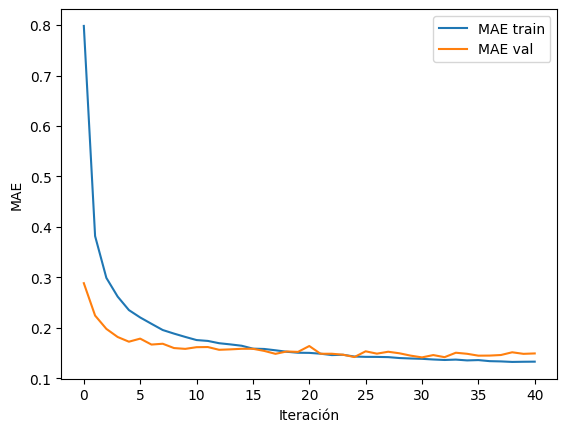

In [17]:
plt.plot(historia.history['mse'],label='MAE train')
plt.plot(historia.history['val_mse'],label='MAE val')
plt.xlabel('Iteración')
plt.ylabel('MAE')
plt.legend();

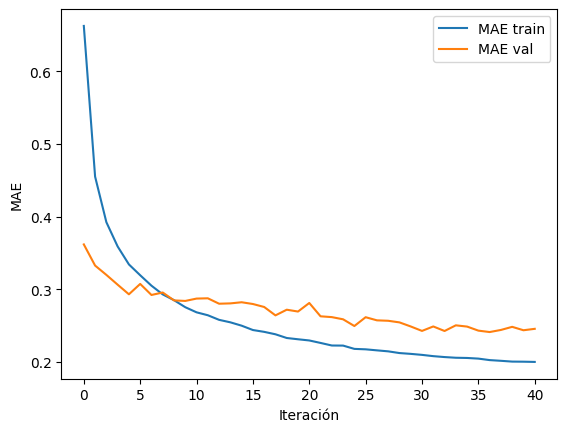

In [18]:
plt.plot(historia.history['mae'],label='MAE train')
plt.plot(historia.history['val_mae'],label='MAE val')
plt.xlabel('Iteración')
plt.ylabel('MAE')
plt.legend();

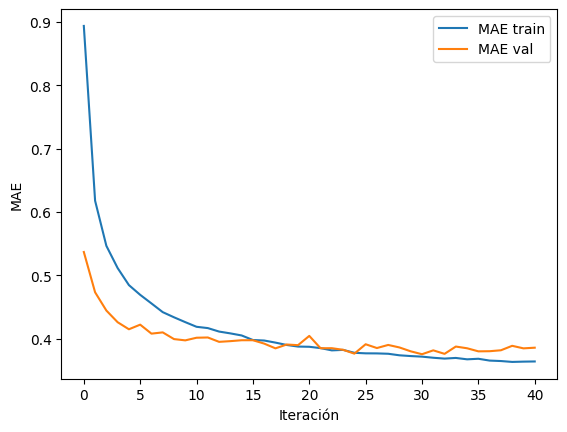

In [21]:
plt.plot(historia.history['root_mean_squared_error'],label='MAE train')
plt.plot(historia.history['val_root_mean_squared_error'],label='MAE val')
plt.xlabel('Iteración')
plt.ylabel('MAE')
plt.legend();

In [49]:
def predecir(x, model, scaler):
    '''Genera la predicción de OUTPUT_LENGTH instantes
    de tiempo a futuro con el modelo entrenado.

    Entrada:
    - x: batch (o batches) de datos para ingresar al modelo
      (tamaño: BATCHES X INPUT_LENGTH X FEATURES)
    - model: Red LSTM entrenada
    - scaler: escalador (requerido para llevar la predicción a la escala original)

    Salida:
    - y_pred: la predicción en la escala original (tamaño: BATCHES X OUTPUT_LENGTH X FEATURES)
    '''

    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x,verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

In [51]:
hpredic=168
a=x_ts_mlp[:hpredic]
pred=predecir(a, model, scaler)
t1 = np.array([])  # Inicializar t1 como un array vacío
t2 = np.array([])  # Inicializar t2 como un array vacío
real = np.array([])  # Inicializar t2 como un array vacío
for i in range(hpredic):
  if i%2 == 0:
    t1= np.concatenate((t1, [pred[i]]))
  else:
    t2=np.concatenate((t2, [pred[i]]))

y_real = y_ts[:168]

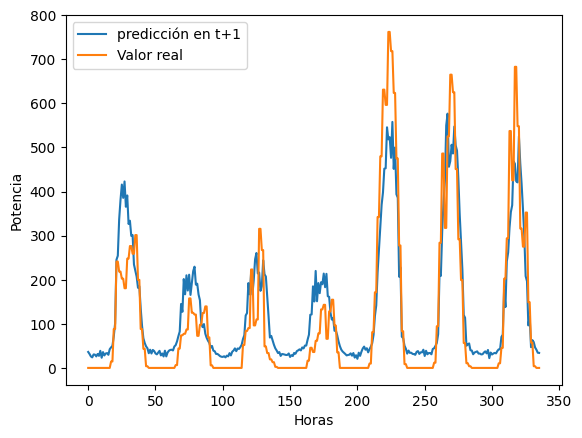

In [52]:
 t1=np.concatenate((t1, [0]))
 t2=np.concatenate(([0], t2))
plt.plot(pred,label='predicción en t+1')
plt.plot(scaler.inverse_transform(y_real[:hpredic].reshape(-1, 1)).reshape(-1),label='Valor real')
plt.xlabel('Horas')
plt.ylabel('Potencia')
plt.legend();